Episode: 2700/3000
Win Rate: 0.0% | Loss Rate: 0.0% | Draw Rate: 100.0%
Exploration: 0.010 | Q-table Size: 7
Time elapsed: 0.7s



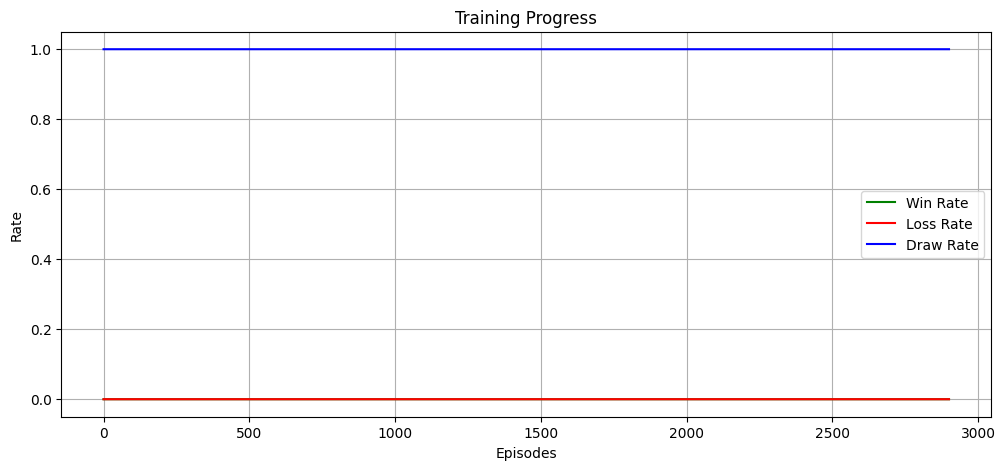


New Game! AI plays as X
Position numbers:

Current Board:
 0 | 1 | 2 
-----------
 3 | 4 | 5 
-----------
 6 | 7 | 8 


AI's turn...
AI chose position 4

Current Board:
 0 | 1 | 2 
-----------
 3 | X | 5 
-----------
 6 | 7 | 8 



In [ ]:
import numpy as np
import random
import time
from IPython.display import clear_output
import matplotlib.pyplot as plt
from collections import deque

class TicTacToe:
    def __init__(self):
        self.board = [' '] * 9
        self.current_player = 'X'
        self.game_over = False
        self.winner = None

    def reset(self):
        self.__init__()
        return tuple(self.board)

    def render(self):
        """Display board with position numbers"""
        print("\nCurrent Board:")
        for i in range(0, 9, 3):
            row = []
            for j in range(3):
                pos = i + j
                row.append(str(pos) if self.board[pos] == ' ' else self.board[pos])
            print(f" {row[0]} | {row[1]} | {row[2]} ")
            if i < 6:
                print("-----------")
        print()

    def available_actions(self):
        return [i for i, spot in enumerate(self.board) if spot == ' ']

    def check_winner(self):
        wins = [(0,1,2),(3,4,5),(6,7,8),
                (0,3,6),(1,4,7),(2,5,8),
                (0,4,8),(2,4,6)]
        for a,b,c in wins:
            if self.board[a] == self.board[b] == self.board[c] != ' ':
                return self.board[a]
        return None

    def step(self, action):
        if self.board[action] != ' ':
            self.game_over = True
            return self.reset(), -15, True, {}  # Stronger penalty

        self.board[action] = self.current_player
        winner = self.check_winner()

        # Adjusted reward system
        reward = 0
        if winner:
            reward = 10 if winner == 'X' else -10  # Reduced victory reward
            self.winner = winner
            self.game_over = True
        elif ' ' not in self.board:
            reward = 0  # Increased draw reward
            self.game_over = True
        else:
            # Defense bonus calculation
            defense_bonus = 5 if self.is_defensive_move(action) else 0
            center_bonus = 3 if action == 4 else 0
            reward = 0.5 + defense_bonus + center_bonus

        self.current_player = 'O' if self.current_player == 'X' else 'X'
        return tuple(self.board), reward, self.game_over, {}

    def is_defensive_move(self, action):
        """Check if the move blocks opponent's potential win"""
        temp_board = self.board.copy()
        temp_board[action] = 'X'

        # Check if this move prevents opponent's win
        wins = [(0,1,2),(3,4,5),(6,7,8),
                (0,3,6),(1,4,7),(2,5,8),
                (0,4,8),(2,4,6)]

        for line in wins:
            values = [temp_board[i] for i in line]
            if values.count('O') == 2 and ' ' in values:
                return True
        return False

class QAgent:
    def __init__(self, lr=0.1, gamma=0.95, eps=1.0, eps_min=0.01, eps_decay=0.995):
        self.q_table = {}
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.eps_min = eps_min
        self.eps_decay = eps_decay
        self.memory = deque(maxlen=10000)
        # Removed pre-training
        # self._pre_train()

    def _update_q(self, state, action, value):
        self.q_table[(state, action)] = value

    def get_action(self, state, actions, training=True):
        # Defense first strategy
        temp_env = TicTacToe()
        temp_env.board = list(state)

        # Check for immediate defensive needs
        for a in actions:
            temp_env.board[a] = 'X'
            if temp_env.check_winner() == 'X':
                return a
            temp_env.board[a] = ' '

            temp_env.board[a] = 'O'
            if temp_env.check_winner() == 'O':
                return a
            temp_env.board[a] = ' '

        # Increased offensive strategy
        if training and random.random() < self.eps * 0.5:  # Increased randomness
            return self._smart_random(actions)

        if 4 in actions:
            return 4

        q_vals = [self.q_table.get((state, a), 0) for a in actions]
        return actions[np.argmax(q_vals)]

    def _smart_random(self, actions):
        priority = [4,0,2,6,8,1,3,5,7]  # Center first, then corners
        for p in priority:
            if p in actions:
                return p
        return random.choice(actions)

    def update(self, state, action, reward, next_state, done):
        old_q = self.q_table.get((state, action), 0)
        future_max = max([self.q_table.get((next_state, a), 0)
                        for a in self.available_actions(next_state)]) if not done else 0
        new_q = old_q + self.lr * (reward + self.gamma * future_max - old_q)
        self.q_table[(state, action)] = new_q

        if self.eps > self.eps_min:
            self.eps *= self.eps_decay

    def available_actions(self, state):
        return [i for i, s in enumerate(state) if s == ' ']

    def _smart_opponent_strategy(self, env):
        opp_actions = env.available_actions()
        temp_env = TicTacToe()
        temp_env.board = env.board.copy()

        # Opponent tries to win
        for a in opp_actions:
            temp_env.board[a] = 'O'
            if temp_env.check_winner() == 'O':
                return a
            temp_env.board[a] = ' '

        # Opponent tries to block AI's win
        for a in opp_actions:
            temp_env.board[a] = 'X'
            if temp_env.check_winner() == 'X':
                return a
            temp_env.board[a] = ' '

        # If no better option, choose randomly
        return self._smart_random(opp_actions)

def train(episodes=3000, batch_size=64):
    env = TicTacToe()
    agent = QAgent()
    metrics = {'wins': [], 'losses': [], 'draws': []}

    print("Training Started...")
    start = time.time()

    for ep in range(episodes):
        state = env.reset()

        while not env.game_over:
            actions = env.available_actions()
            action = agent.get_action(state, actions)
            next_state, reward, done, _ = env.step(action)

            if not done:
                opp_action = agent._smart_opponent_strategy(env)
                next_state, opp_reward, done, _ = env.step(opp_action)

            agent.update(state, action, reward, next_state, done)
            state = next_state

        # Record metrics
        if env.winner == 'X':
            metrics['wins'].append(1)
            metrics['losses'].append(0)
            metrics['draws'].append(0)
        elif env.winner == 'O':
            metrics['wins'].append(0)
            metrics['losses'].append(1)
            metrics['draws'].append(0)
        else:
            metrics['wins'].append(0)
            metrics['losses'].append(0)
            metrics['draws'].append(1)

        # Progress display
        if ep % 300 == 0:
            clear_output(wait=True)
            win_rate = np.mean(metrics['wins'][-100:])
            loss_rate = np.mean(metrics['losses'][-100:])
            draw_rate = np.mean(metrics['draws'][-100:])

            print(f"Episode: {ep}/{episodes}")
            print(f"Win Rate: {win_rate:.1%} | Loss Rate: {loss_rate:.1%} | Draw Rate: {draw_rate:.1%}")
            print(f"Exploration: {agent.eps:.3f} | Q-table Size: {len(agent.q_table)}")
            print(f"Time elapsed: {time.time()-start:.1f}s\n")

    # Plot training results
    plt.figure(figsize=(12, 5))
    window = 100

    plt.plot(np.convolve(metrics['wins'], np.ones(window)/window, mode='valid'),
             label='Win Rate', color='green')
    plt.plot(np.convolve(metrics['losses'], np.ones(window)/window, mode='valid'),
             label='Loss Rate', color='red')
    plt.plot(np.convolve(metrics['draws'], np.ones(window)/window, mode='valid'),
             label='Draw Rate', color='blue')

    plt.title('Training Progress')
    plt.xlabel('Episodes')
    plt.ylabel('Rate')
    plt.legend()
    plt.grid(True)
    plt.show()

    return agent

def play(agent):
    env = TicTacToe()
    state = env.reset()

    print("\nNew Game! AI plays as X")
    print("Position numbers:")
    env.render()

    while not env.game_over:
        if env.current_player == 'X':
            print("\nAI's turn...")
            time.sleep(0.3)
            action = agent.get_action(state, env.available_actions(), training=False)
            print(f"AI chose position {action}")
        else:
            while True:
                try:
                    action = int(input("Your turn (0-8): "))
                    if action in env.available_actions():
                        break
                    print(f"Invalid! Available positions: {env.available_actions()}")
                except:
                    print("Please enter a number 0-8")

        state, _, done, _ = env.step(action)
        env.render()

        if env.winner:
            print(f"Game Over! {'AI (X)' if env.winner == 'X' else 'You (O)'} wins!")
        elif not env.available_actions():
            print("Game Over! It's a draw!")

    return input("\nPlay again? (y/n) ").lower() == 'y'

if __name__ == "__main__":
    ai = train(episodes=3000)
    while True:
        if not play(ai):
            print("Thanks for playing!")
            break